**EIP3.0// Batch 4**
**TUSHAR SHARMA**

basic overview:

1. trained on 64x64 from begining to end
2. 16+16=32// two triangular clr policy runs of 16 epochs each // sgd lr=0.1 mom=0.9 // no aug: **57% val**
3. +16=48// one cosine clr policy of 16 epochs // sgd lr=0.1 mom=0.9 // no aug: **59% val**
4. +16=64// one cosine clr policy of 16 epochs // sgd lr=0.1 mom=0.9 // some aug : **63.19% val**
5. +16=96//cosine clr 16 epochs//sgd// some aug//smooth label **63.0%val**
6. +32=112 // Cosine clr//focal loss// sgd//same augs//smooth label **64.20% val**


**Things tried but opted out:**
1. OHEM(Online Hard Example Mining): wrote pipeline but each epoch was about 15 mins; and I have no patience
2. storing hard examples in directory and custom generator to mix hard and regular example: training improved nicely but somehow validation set was performing like random guessing
3. Augmentation that plays with image colour//colour gradients//hue saturation: training and testing accuracy drops to 0.005 and doesn't recover. tried mellowing the augmentation values, still no use.


# imports// data downloads // mount drive

In [0]:
# https://keras.io/
!pip install -q keras
import keras

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator


# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

#
import os

# Some other needs
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow, imsave
import imageio

Using TensorFlow backend.


In [0]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2019-04-08 10:17:21--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.7MB/s    in 15s     

2019-04-08 10:17:37 (15.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls

gdrive	sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


# THings we'll need at a re-run (probably not)

In [0]:
#COsine learning rate policy
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=4,
                 mult_factor=1):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

# Image augmentations and generator function

## Imageaug dependencies

In [0]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely

In [0]:
!pip install --upgrade scikit-image

In [0]:
!pip install imgaug

Some augmentations

In [0]:
# before 6pm 6april
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def test_augs(batches, blur_value=0.25, crop_value=0.2, flip_value=0.4):
  seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, blur_value)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),
    iaa.Sometimes(0.4,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
  ])
  
  while True:
    batch_x, batch_y = next(batches)
    batch_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    batch_augmented = seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    yield (batch_augmented, batch_y)

In [0]:
# after 6pm 6april

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def test_augs(batches):
  seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 1)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),
    iaa.Sometimes(0.4,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
  ])
  
  while True:
    batch_x, batch_y = next(batches)
    batch_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    batch_augmented = seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    yield (batch_augmented, batch_y)

# Model arch

In [0]:
batch_size = 256
num_classes = 200
epochs = 16

In [0]:
'''
dropout:None
L2:0.001
'''
#begin layers
def conv_bn_relu(input, block_no):
  ch_in = 16*(2**block_no)
  c1 = Conv2D(ch_in, (3,3),
#               kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='glorot_uniform',
              padding='same', 
              name='begin_block{}_conv1'.format(block_no),
              use_bias=False)(input)
  c1 = BatchNormalization(name='begin_block{}_norm1'.format(block_no))(c1)
  c1 = ReLU()(c1)
  
  return c1

# Custom ResBlock
def add_resblock(input, dropout_rate = None, layers=2, block_no=1, first_block=False, final_block=False):

#   ch_in = 32 if input.shape[3]==3 else input.shape[3]*2
  ch_in = input.shape[3]*2
#   ch_in = 32 if first_block else input.shape[3]*2
  temp = input
  
  for l in range(layers):
    c1 = Conv2D(int(ch_in*(2**l)),
                (3,3),
                kernel_regularizer=regularizers.l2(0.001),
#                 kernel_initializer='glorot_uniform',
                use_bias=False,
                padding='same', 
                name = 'res_block{}_conv{}'.format(block_no, l+1))(temp)
    if dropout_rate!=None:
      c1 = Dropout(dropout_rate)(c1)
      
    c1 = BatchNormalization(name = 'res_block{}_BN{}'.format(block_no, l+1))(c1)
        
    c1 = ReLU(name = 'res_block{}_relu{}'.format(block_no, l+1))(c1)
    
    temp = c1

    
  concat = Concatenate(axis=-1)([input,temp])


  if not final_block:

    tr_layer = Conv2D(int(ch_in), (1,1),
                      kernel_regularizer=regularizers.l2(0.001),
                      use_bias=False,
                      padding='same', 
                      name = 'res_block{}_transition'.format(block_no))(concat)
    tr_layer = BatchNormalization(name = 'res_block_transition1x1{}_BN'.format(block_no))(tr_layer)
    tr_layer = ReLU(name = 'res_block_transition1x1{}_relu'.format(block_no))(tr_layer)
    
    
    return MaxPooling2D(pool_size=(2, 2))(tr_layer)
  else:
    return concat

In [0]:
# input = Input(shape=(img_height, img_width, channel,))
# input = Input(shape=train_generator.image_shape)
input = Input(shape=(None, None, 3,))
# input = Input(shape=(32, 32, 3,))
# input = Input(shape=(64, 64, 3,))

First_Conv2D = conv_bn_relu(input, block_no=1)
# second_Conv2D = conv_bn_relu(First_Conv2D, block_no=2)
# first_maxpool = MaxPooling2D(pool_size=(2, 2), name = 'startmaxpool')(First_Conv2D)

block1 = add_resblock(First_Conv2D, layers=2, block_no=1, first_block=True)

block2 = add_resblock(block1, layers=2, block_no=2)

block3 = add_resblock(block2, layers=2, block_no=3)

block4 = add_resblock(block3, layers=2, block_no=4, final_block=True)

reduce_ch = Conv2D(num_classes, (1,1), name='ch_size_no_classes', use_bias=False)(block4)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)

model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
begin_block1_conv1 (Conv2D)     (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
begin_block1_norm1 (BatchNormal (None, None, None, 3 128         begin_block1_conv1[0][0]         
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, None, None, 3 0           begin_block1_norm1[0][0]         
__________________________________________________________________________________________________
res_block1

# Pt1. Epochs 0-16 and17-32 epochs// triangle clr policy //no aug//56.19%Val
1) sgd: lr 0.1; mom: 0.9

no image aug

**DONT RETRAIN NEXT 3BLOCKS ITS ALREADY TRAINED FOR 16+16 EPOCHS WITH CLR POLICY**

In [0]:
#Triangle cyclic learning rate policy

from keras.callbacks import *

class CyclicLR(Callback):
    

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

0-32 already ran and saved **DO NOT RE RUN NEXT TWO BLOCKS**

In [0]:
##1-16 epochs
clr = CyclicLR(base_lr=0.001, max_lr=0.1,
                        step_size=782.)
#2april 14:46 // lr0.1 mom=0.9//64x64 // no aug // 20epochs

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

#generator
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

batch_size = 512
target_size = (32,32)

batch_size = 256
target_size = (64,64)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)
    
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels


# this is a similar generator, for validation data
# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

#fit
model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data=validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1, callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 449s 1s/step - loss: 6.6120 - acc: 0.1050 - val_loss: 7.0621 - val_acc: 0.0564
Epoch 2/16
391/391 [==============================] - 445s 1s/step - loss: 4.7986 - acc: 0.2163 - val_loss: 5.3076 - val_acc: 0.0960
Epoch 3/16
391/391 [==============================] - 445s 1s/step - loss: 3.6166 - acc: 0.3157 - val_loss: 4.2607 - val_acc: 0.1913
Epoch 4/16
391/391 [==============================] - 445s 1s/step - loss: 2.8061 - acc: 0.4434 - val_loss: 3.0364 - val_acc: 0.3931
Epoch 5/16
391/391 [==============================] - 444s 1s/step - loss: 2.5782 - acc: 0.4795 - val_loss: 4.1742 - val_acc: 0.2107
Epoch 6/16
391/391 [==============================] - 445s 1s/step - loss: 3.0444 - acc: 0.3951 - val_loss: 5.6943 - val_acc: 0.1234
Epoch 7/16
391/391 [==============================] - 447s 1s/step - loss: 2.9422 - acc: 0.4372 - val_loss: 3.6

In [0]:
##17-32 epochs
clr = CyclicLR(base_lr=0.001, max_lr=0.1,
                        step_size=782.)
#2april 14:46 // lr0.1 mom=0.9//64x64 // no aug // 20epochs

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

#generator
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)
    
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels


# this is a similar generator, for validation data
# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

#fit
model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data=validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1, callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 451s 1s/step - loss: 1.7439 - acc: 0.7337 - val_loss: 6.3997 - val_acc: 0.1928
Epoch 2/16
391/391 [==============================] - 446s 1s/step - loss: 2.7413 - acc: 0.5385 - val_loss: 6.2464 - val_acc: 0.1536
Epoch 3/16
391/391 [==============================] - 446s 1s/step - loss: 2.8259 - acc: 0.5538 - val_loss: 3.6924 - val_acc: 0.3747
Epoch 4/16
391/391 [==============================] - 446s 1s/step - loss: 2.0014 - acc: 0.7096 - val_loss: 2.5668 - val_acc: 0.5666
Epoch 5/16
391/391 [==============================] - 447s 1s/step - loss: 1.6427 - acc: 0.7809 - val_loss: 4.1567 - val_acc: 0.3413
Epoch 6/16
391/391 [==============================] - 447s 1s/step - loss: 2.7895 - acc: 0.5522 - val_loss: 4.8562 - val_acc: 0.2622
Epoch 7/16
391/391 [==============================] - 447s 1s/step - loss: 2.8599 - acc: 0.5696 - val_loss: 3.7

MOdel saved

In [0]:
#Have saved the model 22:53//2april
# model.save('/content/gdrive/My Drive/april02epoch48_acc77_valacc56.h5')

### load saved model

In [0]:
from keras.models import load_model
#load model back
model = load_model('/content/gdrive/My Drive/april02epoch48_acc77_valacc56.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#Pt2. Epochs: 33-48 //cosine clr // +16=48 epochs // no aug //59.23%val

change clr to cosine policy

In [0]:
#COsine learning rate policy
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=4,
                 mult_factor=1):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [0]:
##33-48 epochs
#5april 1:35 // lr0.1 mom=0.9//64x64 // no aug // 16 epochs


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels


########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 469s 1s/step - loss: 3.1432 - acc: 0.5465 - val_loss: 4.7676 - val_acc: 0.3014
Epoch 2/16
391/391 [==============================] - 446s 1s/step - loss: 2.7175 - acc: 0.6154 - val_loss: 3.6622 - val_acc: 0.4125
Epoch 3/16
391/391 [==============================] - 446s 1s/step - loss: 1.9348 - acc: 0.7587 - val_loss: 2.9531 - val_acc: 0.5101
Epoch 4/16
391/391 [==============================] - 446s 1s/step - loss: 1.2200 - acc: 0.9313 - val_loss: 2.5116 - val_acc: 0.5962
Epoch 5/16
391/391 [==============================] - 445s 1s/step - loss: 3.0079 - acc: 0.5600 - val_loss: 4.6740 - val_acc: 0.3032
Epoch 6/16
391/391 [==============================] - 446s 1s/step - loss: 2.6036 - acc: 0.6405 - val_loss: 3.7430 - val_acc: 0.4139
Epoch 7/16
391/391 [==============================] - 445s 1s/step - loss: 1.8119 - acc: 0.7897 - val_loss: 2.8

## save and load model

In [0]:
# save model
#model.save('/content/gdrive/My Drive/april06epoch48_acc98_valacc59_noaug.h5')

In [0]:
from keras.models import load_model
#load model back
model = load_model('/content/gdrive/My Drive/april06epoch48_acc98_valacc59_noaug.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#Pt3. Epochs: 49-80(32) //cosine clr // with some aug//63.19%val


In [0]:
# 7april augs
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def april7_augs(batches):
  shape_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.25)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),

    iaa.Sometimes(0.10, iaa.CropAndPad(percent=(0, .20))),
      
    iaa.Sometimes(0.5,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),  
    
  ])
  
  # for weird reasons most color augmentations of image aug work only on 'uint8'
  clr_seq = iaa.Sometimes(0.1, iaa.OneOf([iaa.AddToHueAndSaturation((-40, 40)),
                                     iaa.FrequencyNoiseAlpha(
                                         exponent=(-4, 0),
                                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                         second=iaa.ContrastNormalization((0.5, 2.0)))]
                                     ))
  
  while True:
    batch_x, batch_y = next(batches)
    shape_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    
    #Shape Augmentations
    shape_augmented = shape_seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    
    #Colour augmentations; because most of the colour augmentations only work with np type 'uint8'
#     clr_augmented = shape_seq.augment_images(shape_augmented.astype('uint8'))
    
    yield (shape_augmented, batch_y)
#     yield (clr_augmented, batch_y)

In [0]:
##49-64 epochs one more try
#7april 03:30 
##lr0.1 mom=0.9 nesterov//64x64 // someaug // 64 epochs


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

########################
# Compile with focal loss
########################

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])
  
# model.compile(loss=focal_loss(alpha=0.25),
#               optimizer=sgd,
#               metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

##add augmentations/ smooth the labels
train_aug_generator = april7_augs(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=32,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/32
391/391 [==============================] - 460s 1s/step - loss: 4.1125 - acc: 0.3462 - val_loss: 4.5219 - val_acc: 0.3096
Epoch 2/32
391/391 [==============================] - 454s 1s/step - loss: 3.5730 - acc: 0.4215 - val_loss: 3.6450 - val_acc: 0.3927
Epoch 3/32
391/391 [==============================] - 454s 1s/step - loss: 3.0205 - acc: 0.4932 - val_loss: 2.8842 - val_acc: 0.5136
Epoch 4/32
391/391 [==============================] - 454s 1s/step - loss: 2.5213 - acc: 0.5783 - val_loss: 2.4436 - val_acc: 0.5978
Epoch 5/32
391/391 [==============================] - 454s 1s/step - loss: 3.5892 - acc: 0.4052 - val_loss: 5.5542 - val_acc: 0.1979
Epoch 6/32
391/391 [==============================] - 454s 1s/step - loss: 3.3362 - acc: 0.4481 - val_loss: 3.7981 - val_acc: 0.3640
Epoch 7/32
391/391 [==============================] - 454s 1s/step - loss: 2.8609 - acc: 0.5177 - val_loss: 2.7

In [0]:
# save model
model.save('/content/gdrive/My Drive/april08epoch80_acc67_valacc63_someaug.h5')

# Pt4. Epochs: 81-96(16)//cosine clr//same aug//soft label//





In [0]:
from keras.models import load_model
#load model back
model = load_model('/content/gdrive/My Drive/april08epoch80_acc67_valacc63_someaug.h5')

In [0]:
#Smooth criminals
def smooth_labels(y, smooth_factor=0.1):
  y *= 1 - smooth_factor
  y += smooth_factor / y.shape[1]
  
  return y

In [0]:
# kill two birds with one stone: smooth and aug in same go
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def Xaugs_ysmooth(batches):
  shape_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.25)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),

    iaa.Sometimes(0.10, iaa.CropAndPad(percent=(0, .20))),
      
    iaa.Sometimes(0.5,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),  
    
  ])
  
  # for weird reasons most color augmentations of image aug work only on 'uint8'
  clr_seq = iaa.Sometimes(0.1, iaa.OneOf([iaa.AddToHueAndSaturation((-40, 40)),
                                     iaa.FrequencyNoiseAlpha(
                                         exponent=(-4, 0),
                                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                         second=iaa.ContrastNormalization((0.5, 2.0)))]
                                     ))
  
  while True:
    batch_x, batch_y = next(batches)
    shape_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    
    #Shape Augmentations
    shape_augmented = shape_seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    
    #Colour augmentations; because most of the colour augmentations only work with np type 'uint8'
    clr_augmented = shape_seq.augment_images(shape_augmented.astype('uint8'))
    
    #smooth criminals
    smooth_y = smooth_labels(batch_y)
    
    yield (shape_augmented, smooth_y)
#     yield (clr_augmented, batch_y)

In [0]:
##49-64 epochs one more try
#7april 03:30 
##lr0.1 mom=0.9 nesterov//64x64 // someaug // 64 epochs


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

########################
# Compile with focal loss
########################

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])
  
# model.compile(loss=focal_loss(alpha=0.25),
#               optimizer=sgd,
#               metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

##add augmentations/ smooth the labels
train_aug_generator = Xaugs_ysmooth(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 478s 1s/step - loss: 3.9311 - acc: 0.4391 - val_loss: 3.5465 - val_acc: 0.4073
Epoch 2/16
391/391 [==============================] - 454s 1s/step - loss: 3.7048 - acc: 0.4780 - val_loss: 3.5766 - val_acc: 0.3659
Epoch 3/16
391/391 [==============================] - 454s 1s/step - loss: 3.2854 - acc: 0.5511 - val_loss: 2.6049 - val_acc: 0.5469
Epoch 4/16
391/391 [==============================] - 454s 1s/step - loss: 2.9119 - acc: 0.6371 - val_loss: 2.1971 - val_acc: 0.6189
Epoch 5/16
391/391 [==============================] - 454s 1s/step - loss: 3.7578 - acc: 0.4496 - val_loss: 3.9401 - val_acc: 0.3280
Epoch 6/16
391/391 [==============================] - 454s 1s/step - loss: 3.5843 - acc: 0.4924 - val_loss: 3.0494 - val_acc: 0.4672
Epoch 7/16
391/391 [==============================] - 454s 1s/step - loss: 3.2104 - acc: 0.5610 - val_loss: 2.5

In [0]:
# save model
#model.save('/content/gdrive/My Drive/april08epoch96_acc65_valacc624_xaugysmooth.h5')


_________________________________________________________________________

# Pt5. Epoch: 96-128(32)//one last ride:image aug//cosine clr// Focal loss//  with label smoothing

In [0]:
from keras.models import load_model
#load model back
model = load_model('/content/gdrive/My Drive/april08epoch96_acc65_valacc624_xaugysmooth.h5')

In [0]:
#COsine learning rate policy
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=4,
                 mult_factor=1):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [0]:
#code for focal loss, with gamma=2.0 and alpha= 0.25
def focal_loss(gamma=4., alpha=0.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [0]:
#Smooth criminals
def smooth_labels(y, smooth_factor=0.1):
  y *= 1 - smooth_factor
  y += smooth_factor / y.shape[1]
  
  return y

In [0]:
# kill two birds with one stone: smooth and aug in same go
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def Xaugs_ysmooth(batches):
  shape_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.25)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),

    iaa.Sometimes(0.10, iaa.CropAndPad(percent=(0, .20))),
      
    iaa.Sometimes(0.5,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),  
    
  ])
  
  # for weird reasons most color augmentations of image aug work only on 'uint8'
  clr_seq = iaa.Sometimes(0.1, iaa.OneOf([iaa.AddToHueAndSaturation((-40, 40)),
                                     iaa.FrequencyNoiseAlpha(
                                         exponent=(-4, 0),
                                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                         second=iaa.ContrastNormalization((0.5, 2.0)))]
                                     ))
  
  while True:
    batch_x, batch_y = next(batches)
    shape_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    
    #Shape Augmentations
    shape_augmented = shape_seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    
    #Colour augmentations; because most of the colour augmentations only work with np type 'uint8'
    clr_augmented = shape_seq.augment_images(shape_augmented.astype('uint8'))
    
    #smooth criminals
    smooth_y = smooth_labels(batch_y)
    
    yield (shape_augmented, smooth_y)
#     yield (clr_augmented, batch_y)

In [0]:
##97-112 epochs
#7april 03:30 
##lr0.1 mom=0.9 nesterov//64x64 // someaug // 64 epochs//reduce at plateau//softlabel//focal loss


########################
# Compile and cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.005,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                               factor=0.1, patience=10,
#                                               min_lr=0.001)

########################
# Compile with focal loss
########################

#SDG 
sgd = SGD(lr=0.005, momentum = 0.9, nesterov=True)

# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
  
model.compile(loss=focal_loss(alpha=0.25),
              optimizer=sgd,
              metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

##add augmentations/ smooth the labels
train_aug_generator = Xaugs_ysmooth(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=32,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/32
391/391 [==============================] - 481s 1s/step - loss: 0.7379 - acc: 0.6835 - val_loss: 0.8145 - val_acc: 0.6310
Epoch 2/32
391/391 [==============================] - 468s 1s/step - loss: 0.7005 - acc: 0.6793 - val_loss: 0.7817 - val_acc: 0.6319
Epoch 3/32
391/391 [==============================] - 468s 1s/step - loss: 0.6678 - acc: 0.6929 - val_loss: 0.7613 - val_acc: 0.6339
Epoch 4/32
391/391 [==============================] - 468s 1s/step - loss: 0.6544 - acc: 0.6937 - val_loss: 0.7520 - val_acc: 0.6349
Epoch 5/32
391/391 [==============================] - 468s 1s/step - loss: 0.6340 - acc: 0.6920 - val_loss: 0.7233 - val_acc: 0.6332
Epoch 6/32
391/391 [==============================] - 468s 1s/step - loss: 0.6029 - acc: 0.6956 - val_loss: 0.6969 - val_acc: 0.6365
Epoch 7/32
391/391 [==============================] - 468s 1s/step - loss: 0.5817 - acc: 0.7011 - val_loss: 0.6

In [0]:
# save model
model.save('/content/gdrive/My Drive/april08epoch112_acc___valacc___xaugysmooth_focalloss_lastride1.h5')


# Finish.
everything after this block has all the things I have tried, but didn't work out. They are not part of the final run.
_________________________________________________________________________

# Graveyard of Ideas

#Meh :B. test for 32epochs with huesaturation/colour augs

In [0]:
# 7april colour augs try
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def april7_augs(batches):
  shape_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.25)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 20% of all images) 
    
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),

    iaa.Sometimes(0.10, iaa.CropAndPad(percent=(0, .20))),
      
    iaa.Sometimes(0.5,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),  
    
  ])
  
  # for weird reasons most color augmentations of image aug work only on 'uint8'
  clr_seq = iaa.Sometimes(0.1, iaa.OneOf([iaa.AddToHueAndSaturation((-20, 20)),
                                     iaa.FrequencyNoiseAlpha(
                                         exponent=(-4, 0),
                                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                         second=iaa.ContrastNormalization((0.5, 2.0)))]
                                     ))
  
  while True:
    batch_x, batch_y = next(batches)
    shape_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    
    #Shape Augmentations
    shape_augmented = shape_seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    
    #Colour augmentations; astype('uint8')because most of the colour augmentations only work with np type 'uint8' with opencv hooks
    clr_augmented = shape_seq.augment_images(shape_augmented.astype('uint8'))
    
#     yield (shape_augmented, batch_y)
    yield (clr_augmented.astype('float32'), batch_y)

In [0]:
##49-64 epochs one more try
#7april 03:30 
##lr0.1 mom=0.9 nesterov//64x64 // someaug // 64 epochs


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

########################
# Compile with focal loss
########################

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])
  
# model.compile(loss=focal_loss(alpha=0.25),
#               optimizer=sgd,
#               metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

##add augmentations/ smooth the labels
train_aug_generator = april7_augs(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=32,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/32
285/391 [====================>.........] - ETA: 1:59 - loss: 5.2331 - acc: 0.0179

KeyboardInterrupt: ignored

# Meh pt3: cosine cyclic rate 49-64 epochs; some aug

Model over fitting, some imageaug may help

In [0]:
##65-80 epochs
#5april 1:35 // lr0.1 mom=0.9, nesterov//64x64 // no aug // 16 epochs


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

###add augmentations
train_aug_generator = test_augs(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 472s 1s/step - loss: 4.0038 - acc: 0.3725 - val_loss: 4.6253 - val_acc: 0.2874
Epoch 2/16
391/391 [==============================] - 449s 1s/step - loss: 3.4424 - acc: 0.4489 - val_loss: 3.7877 - val_acc: 0.3771
Epoch 3/16
391/391 [==============================] - 450s 1s/step - loss: 2.9098 - acc: 0.5193 - val_loss: 2.8590 - val_acc: 0.5185
Epoch 4/16
391/391 [==============================] - 450s 1s/step - loss: 2.4008 - acc: 0.6074 - val_loss: 2.4371 - val_acc: 0.6040
Epoch 5/16
391/391 [==============================] - 448s 1s/step - loss: 3.5110 - acc: 0.4230 - val_loss: 4.4446 - val_acc: 0.3066
Epoch 6/16
391/391 [==============================] - 450s 1s/step - loss: 3.2515 - acc: 0.4690 - val_loss: 3.3704 - val_acc: 0.4343
Epoch 7/16
391/391 [==============================] - 449s 1s/step - loss: 2.7194 - acc: 0.5484 - val_loss: 2.7

In [0]:
# save model
# model.save('/content/gdrive/My Drive/april06epoch64_acc65_valacc624_testaug.h5')


In [0]:
from keras.models import load_model
#load model back
model = load_model('./gdrive/My Drive/april06epoch64_acc65_valacc624_testaug.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Meh training pt4: focal loss// cosine clr // +16=80th epochs// Augmentation/ label smoothing

## Focal loss// image aug with label smoothing

In [0]:
#code for focal loss, with gamma=2.0 and alpha= 0.25
def focal_loss(gamma=2., alpha=0.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [0]:
def smooth_labels(y, smooth_factor=0.1):
  y *= 1 - smooth_factor
  y += smooth_factor / y.shape[1]
  
  return y

In [0]:
#killing two birds with one stone:
# X gets the aug and y gets label smoothing
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def Xaugs_ysmooth(batches):
  seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 1)), # ex: 0.4
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.15), # vertically flip 15% of all images) 
    iaa.Sometimes(0.4, iaa.OneOf([#iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((.08,.2), size_percent=(0.05, 0.05)),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),                    
                ])),
    iaa.Sometimes(0.4,iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=0, # use nearest neighbour or bilinear interpolation (fast)
            mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
  ])
  
  while True:
    batch_x, batch_y = next(batches)
    batch_augmented = np.zeros((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], batch_x.shape[3])) 
    # NOTE: imgaug works on color images (3 channels). doesn't work on greyscale images with one channel
    batch_augmented = seq.augment_images(batch_x) # calling ImgAug's augmentation on a batch of images
    
    #make y happy too
    smooth_y = smooth_labels(batch_y)
    
    yield (batch_augmented, smooth_y)

In [0]:
##65-80 epochs one more try
#6april 14:47 
##lr0.1 mom=0.9 nesterov//64x64 // someaug // 16 epochs// focal loss// smoothlabel


########################
# Compile and clr:cosine clr
########################
clr = SGDRScheduler(0.001,
                 0.1,
                 391,
                 lr_decay=0.9,
                 cycle_length=4,
                 mult_factor=1,
                   )

########################
# Compile with focal loss
########################

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
# #               optimizer='rmsprop',
#               optimizer=sgd,
#               metrics=['accuracy'])
  
model.compile(loss=focal_loss(gamma=4.,alpha=0.25),
              optimizer=sgd,
              metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

##add augmentations/ smooth the labels
train_aug_generator = Xaugs_ysmooth(train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
#         train_generator,
        train_aug_generator,
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data = validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/16
391/391 [==============================] - 458s 1s/step - loss: 0.8251 - acc: 0.5063 - val_loss: 1.1410 - val_acc: 0.2404
Epoch 2/16
391/391 [==============================] - 435s 1s/step - loss: 0.6506 - acc: 0.4817 - val_loss: 0.7276 - val_acc: 0.4598
Epoch 3/16
391/391 [==============================] - 435s 1s/step - loss: 0.5379 - acc: 0.5388 - val_loss: 0.6175 - val_acc: 0.5261
Epoch 4/16
391/391 [==============================] - 435s 1s/step - loss: 0.4370 - acc: 0.6236 - val_loss: 0.5123 - val_acc: 0.6081
Epoch 5/16
391/391 [==============================] - 435s 1s/step - loss: 0.6692 - acc: 0.4236 - val_loss: 1.1208 - val_acc: 0.2538
Epoch 6/16
391/391 [==============================] - 435s 1s/step - loss: 0.6217 - acc: 0.4625 - val_loss: 0.7441 - val_acc: 0.4183
Epoch 7/16
391/391 [=============

In [0]:
# save model
model.save('/content/gdrive/My Drive/april06epoch80_acc___valacc___heavyaug_focalloss1.h5')

# OHEM

In [0]:
#ohem function
def mine_hard_samples(model, datagen, batch_size=256):
  while True:
    samples, targets = [], []
    while len(samples) < batch_size:
      x_data, y_data = next(datagen)
      preds = model.predict(x_data)
      #print("some prediction is happening to get error")
      errors = np.abs(preds - y_data).max(axis=-1) > .6
      samples += x_data[errors].tolist()
      targets += y_data[errors].tolist()

    regular_samples = batch_size * 2 - len(samples)
    x_data, y_data = next(datagen)
    samples += x_data[:regular_samples].tolist()
    targets += y_data[:regular_samples].tolist()

    samples, targets = map(np.array, (samples, targets))

    idx = np.arange(batch_size * 2)
    np.random.shuffle(idx)

    yield samples[idx[:batch_size]], targets[idx[:batch_size]]

In [0]:
#ohem datagenerator 
ohem_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 32x32
    batch_size=batch_size,
    class_mode='categorical')

Found 100000 images belonging to 200 classes.


In [0]:
#ohem model run
def valid_main(model):
  #model = model
  
  #This part is weird; had to add these two lines to kick start predict in this game
  x, y = next(ohem_generator)
  model.predict(x)
  
  
  
  model.fit_generator(
        mine_hard_samples(model, ohem_generator),
        steps_per_epoch = 391, #100000 // batch_size,
        epochs=16,
        validation_data=validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1, callbacks=[clr],
        )

In [0]:
valid_main(model)

Epoch 1/16
122/391 [========>.....................] - ETA: 1:43:11 - loss: 1.3811 - acc: 0.9646

# predict and save hard samples route
1. predict and save hard examples
2. create another generator which takes data from hard examples directory
3. mix train generator and hard generator


solve idx/classname mixmatch:
passible options:

1. take idx 



In [0]:
#hard function_saver : returns nothing just saves hard images at r'./tiny-imagenet-200_hard
from matplotlib.pyplot import imshow, imsave
import os
def hard_samples_saver(model, datagen, threshold=0.7):
  samples, targets = [], []
  datagen_idx_class = {v: k for k, v in datagen.class_indices.items()}
  for i in range(len(datagen)):
    #print(i)
    x_data, y_data = next(datagen)
    #print("some prediction is about to start")
    preds = model.predict(x_data)
    #print("some prediction just happened")
    errors = np.abs(preds - y_data).max(axis=-1) > threshold
    samples= x_data[errors]
    targets = y_data[errors].argmax(axis=-1)
    
    for j in range(samples.shape[0]):
      label = datagen_idx_class[targets[j]]
      if not os.path.exists(r'./tiny-imagenet-200_hard/train/{}'.format(label)):
        os.makedirs(r'./tiny-imagenet-200_hard/train/{}'.format(label))
      imsave(r'./tiny-imagenet-200_hard/train/{}/{}_{}.JPEG'.format(label, label, j), samples[j])

In [0]:
hard_samples_saver(model, train_generator, threshold=0.7)

## hard:regular::50:50 generator

In [0]:
#Train data generator
batch_size = 256
target_size = (64,64)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,

    horizontal_flip=False)
    
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

#################################################################################
##Hard sample generator
batch_size = 256
target_size = (64,64)

# this is the augmentation configuration we will use for training
hard_datagen = ImageDataGenerator(
    rescale=1./255)
    

# batches of augmented image data
hard_generator = hard_datagen.flow_from_directory(
    r'./tiny-imagenet-200_hard/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

Found 100000 images belonging to 200 classes.
Found 6063 images belonging to 200 classes.


In [0]:
#mix soft with hard
def hard_train_gen(train_generator, hard_generator, batch_size=256):
  while True:
    x_train, y_train = next(train_generator)
    x_hard, y_hard = next(hard_generator)

    samples = np.append(x_train, x_hard, axis=0)
    targets = np.append(y_train, y_hard, axis=0)
    
    idx = np.arange(len(samples))
    np.random.shuffle(idx)
    
    yield samples[idx[:batch_size]], targets[idx[:batch_size]]
  

check if indices match

In [0]:
train_generator.class_indices

In [0]:
hard_generator.class_indices

In [0]:
validation_generator.class_indices

## training on mix of hard and normal examples

In [0]:
##17-32 epochs
#4april 20:15 // lr0.1 mom=0.85//64x64 // hard training // 16 epochs


########################
# Compile and clr
########################
clr = CyclicLR(base_lr=0.001, max_lr=0.1,
                        step_size=782.)

#SDG 
sgd = SGD(lr=0.1, momentum = 0.85)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

########################
# Generators
########################
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# batch_size = 1024
# target_size = (16,16)

# batch_size = 512
# target_size = (32,32)

batch_size = 256
target_size = (64,64)

########################
# Train generator
########################
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)
    horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

########################
# Hard sample generator
########################
batch_size = 256
target_size = (64,64)

# this is the augmentation configuration we will use for training
hard_datagen = ImageDataGenerator()
#     rescale=1./255)
    
# batches of augmented image data
hard_generator = hard_datagen.flow_from_directory(
    r'./tiny-imagenet-200_hard/train/',  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')  # since we use categorical_crossentropy loss, we need binary labels

########################
# Hard-train mixer generator
########################

hard_train_generator = hard_basic_gen(hard_generator, train_generator)

########################
# Valid sample generator
########################
valid_datagen = ImageDataGenerator(rescale=1./255)

df = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',
                 sep = "\t", usecols=[0, 1], names = ['filename', 'class'])

validation_generator = valid_datagen.flow_from_dataframe(dataframe = df,
                                                        directory='./tiny-imagenet-200/val/images',
                                                        x_col='filename', y_col='class', 
                                                        target_size= (64,64),
#                                                         target_size= target_size,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

########################
# fit model with hard and train
########################
model.fit_generator(
        hard_basic_gen(train_generator, hard_generator),
        steps_per_epoch = len(train_generator), #100000 // batch_size,
        epochs=16,
        validation_data=validation_generator,
        validation_steps = len(validation_generator), #10000 // batch_size,
        verbose=1,
        callbacks=[clr],
        )

Found 100000 images belonging to 200 classes.
Found 6063 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/16
391/391 [==============================] - 472s 1s/step - loss: 3.9198 - acc: 0.4184 - val_loss: 6.0748 - val_acc: 0.0053
Epoch 2/16
391/391 [==============================] - 465s 1s/step - loss: 4.0516 - acc: 0.3608 - val_loss: 13.9429 - val_acc: 0.0050
Epoch 3/16
391/391 [==============================] - 465s 1s/step - loss: 3.1308 - acc: 0.5297 - val_loss: 10.5132 - val_acc: 0.0054
Epoch 4/16
391/391 [==============================] - 466s 1s/step - loss: 2.1607 - acc: 0.6514 - val_loss: 7.2288 - val_acc: 0.0098
Epoch 5/16
391/391 [==============================] - 465s 1s/step - loss: 1.8105 - acc: 0.7156 - val_loss: 10.5546 - val_acc: 0.0050
Epoch 6/16
391/391 [==============================] - 462s 1s/step - loss: 3.1449 - acc: 0.5494 - val_loss: 9.5808 - val_acc: 0.0046
Epoch 7/16
391/391 [==============================] - 462s 1s/st

KeyboardInterrupt: ignored

In [0]:
scores = model.evaluate_generator(validation_generator, steps= len(validation_generator), verbose=0)

In [0]:
scores

[5.166665706634522, 0.0927]

## Predictions // confusion matrix // most confused

In [0]:
##predictions
pred_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    r'./tiny-imagenet-200/train/',  # this is the target directory
    target_size=(64,64),  # all images will be resized to 150x150
    batch_size=512,
    class_mode='categorical')

y_true = pred_generator.classes

target_names = list(pred_generator.class_indices.keys())

y_pred = model.predict_generator(pred_generator,196)
y_classes = y_pred.argmax(axis=-1)


##confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true, y_classes)

Found 100000 images belonging to 200 classes.


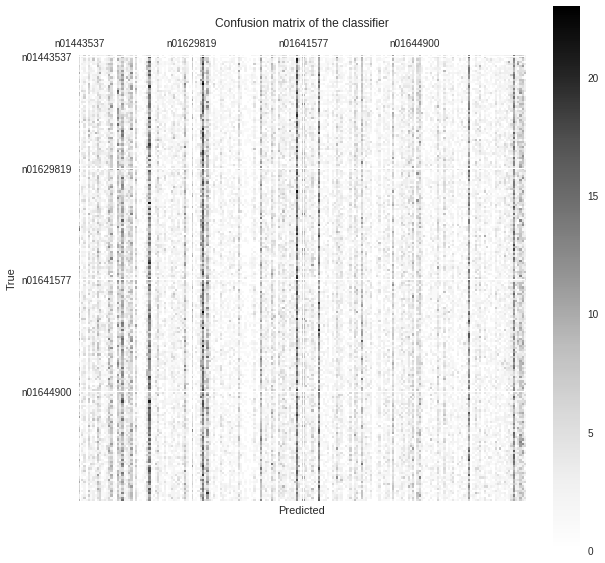

In [0]:
##plot
import matplotlib.pyplot as plt
import numpy as np
labels = target_names

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [0]:
generator_cls_idx = train_generator.class_indices
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

idx_to_name = {v: cls_name_dict[k] for v, k in idx_to_class.items()}

def most_confused_class(cm, min_val=15):
    np.fill_diagonal(cm, 0)
    res = [(idx_to_class[i],idx_to_class[j],cm[i,j])
            for i,j in zip(*np.where(cm>=min_val))]
    return sorted(res, reverse=True)

In [0]:
most_confused_class(cm, min_val=20)

[('n04328186', 'n02123394', 21),
 ('n03937543', 'n02481823', 21),
 ('n03814639', 'n03444034', 21),
 ('n03804744', 'n02481823', 20),
 ('n03733131', 'n03179701', 20),
 ('n03662601', 'n02481823', 23),
 ('n03255030', 'n03179701', 20),
 ('n03089624', 'n02123394', 20),
 ('n02963159', 'n03179701', 20),
 ('n02909870', 'n03179701', 20),
 ('n02793495', 'n02123394', 22),
 ('n02699494', 'n03179701', 22),
 ('n02125311', 'n02481823', 20),
 ('n02099712', 'n03179701', 20),
 ('n01910747', 'n02481823', 23),
 ('n01641577', 'n03179701', 21),
 ('n01629819', 'n02481823', 20)]

In [0]:
def most_confused_name(cm, min_val=15):
    np.fill_diagonal(cm, 0)
    res = [(idx_to_name[i],idx_to_name[j],cm[i,j])
            for i,j in zip(*np.where(cm>=min_val))]
    return sorted(res, reverse=True)
most_confused_name(cm, min_val=20)

[('stopwatch, stop watch', 'Persian cat', 21),
 ('pill bottle', 'chimpanzee, chimp, Pan troglodytes', 21),
 ('neck brace', 'go-kart', 21),
 ('nail', 'chimpanzee, chimp, Pan troglodytes', 20),
 ('maypole', 'desk', 20),
 ('lifeboat', 'chimpanzee, chimp, Pan troglodytes', 23),
 ('jellyfish', 'chimpanzee, chimp, Pan troglodytes', 23),
 ('dumbbell', 'desk', 20),
 ('cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
  'chimpanzee, chimp, Pan troglodytes',
  20),
 ('confectionery, confectionary, candy store', 'Persian cat', 20),
 ('cardigan', 'desk', 20),
 ('bullfrog, Rana catesbeiana', 'desk', 21),
 ('bucket, pail', 'desk', 20),
 ('barn', 'Persian cat', 22),
 ('altar', 'desk', 22),
 ('Labrador retriever', 'desk', 20),
 ('European fire salamander, Salamandra salamandra',
  'chimpanzee, chimp, Pan troglodytes',
  20)]

# Image aug playground

Original:


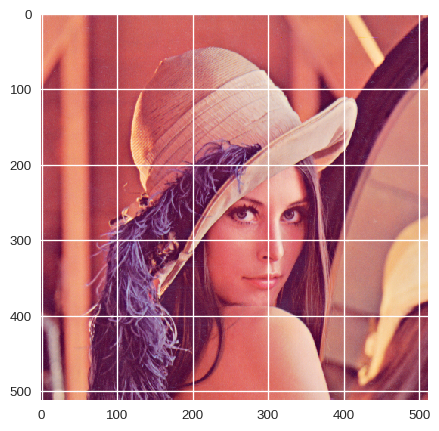

In [0]:
# Example from imgaug...just to check if the library works properly after installing
import imageio
import imgaug as ia
from imgaug import augmenters as iaa


image = imageio.imread("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")
image1 = imageio.imread('tiny-imagenet-200/train/n02190166/images/n02190166_360.JPEG')
image2 =imageio.imread('tiny-imagenet-200/train/n02481823/images/n02481823_0.JPEG')
print("Original:")
ia.imshow(image)

original;


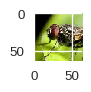

Augmented:


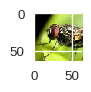

In [0]:
# seq= iaa.CoarseDropout((.2,.2), size_percent=(0.02, 0.02))
seq= iaa.FrequencyNoiseAlpha(exponent=(-4, 0),
                             first=iaa.Multiply((0.7, 1.3), per_channel=True),
                             second=iaa.ContrastNormalization((0.5, 1.5)))
     

# seq =     iaa.Sometimes(0.40, iaa.CropAndPad(percent=(0, .45)))


image_aug = seq.augment_image(image1)

print("original;")
ia.imshow(image1)
print("Augmented:")
ia.imshow(image_aug)

In [0]:
help(iaa.FrequencyNoiseAlpha(exponent=(-4, 0),
                             first=iaa.Multiply((0.5, 1.5), per_channel=True),
                             second=iaa.ContrastNormalization((0.5, 2.0))))

Help on AlphaElementwise in module imgaug.augmenters.blend object:

class AlphaElementwise(Alpha)
 |  Augmenter to blend two image sources pixelwise alpha/transparency values.
 |  
 |  This is the same as ``Alpha``, except that the transparency factor is
 |  sampled per pixel instead of once per image (or a few times per image, if
 |  per_channel is True).
 |  
 |  See ``Alpha`` for more description.
 |  
 |  dtype support::
 |  
 |      See :func:`imgaug.augmenters.blend.blend_alpha`.
 |  
 |  Parameters
 |  ----------
 |  factor : number or tuple of number or list of number or imgaug.parameters.StochasticParameter, optional
 |      Weighting of the results of the first branch. Values close to 0 mean
 |      that the results from the second branch (see parameter `second`)
 |      make up most of the final image.
 |  
 |          * If float, then that value will be used for all images.
 |          * If tuple ``(a, b)``, then a random value from range ``a <= x <= b`` will
 |            